In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch.nn as nn
import torch
from IMS import IMS

# random seed for reproducibility
torch.manual_seed(2)

In [2]:
preprocess = IMS(data_path="C://GSH//Data//IMS//IMS", test_idx=2, sensor_idx=1)
dataset_train, dataset_test = preprocess(train_samples = 300, spectrum=True)
rms = preprocess.rms_trend()

# Data Introduction

The data is from the public NASA bearing experiment data (IMS)

* official website: https://data.nasa.gov/dataset/ims-bearings

This is a bearing life dataset, the experiment started runing the bearing from the health state to the fault state. Every 10 minutes, they record the bearing vibration with $fs=20480$ and $t=1s$. The RMS of the selected experiment 2 is as follows:

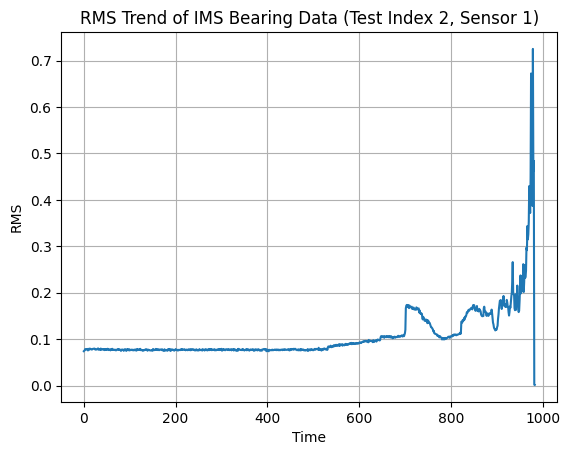

In [3]:
plt.plot(rms)
plt.grid()
plt.title("RMS Trend of IMS Bearing Data (Test Index 2, Sensor 1)")
plt.xlabel("Time")
plt.ylabel("RMS")
plt.show()

We could have a look at the detail of the signal. Two signals, the first the one is the signal collected at the very first stage of the bearing life expriment. The second sigal is collected as the final sample.

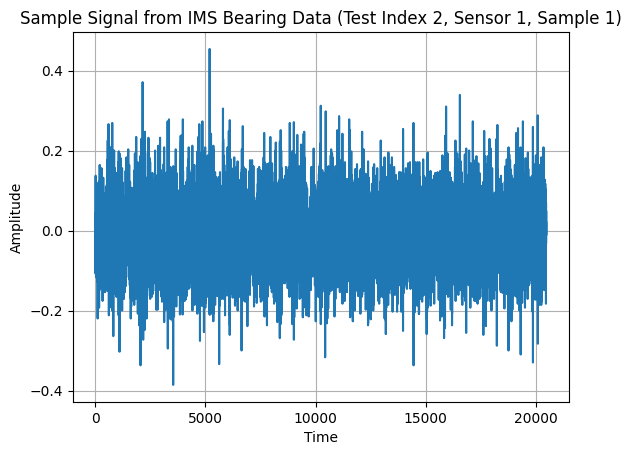

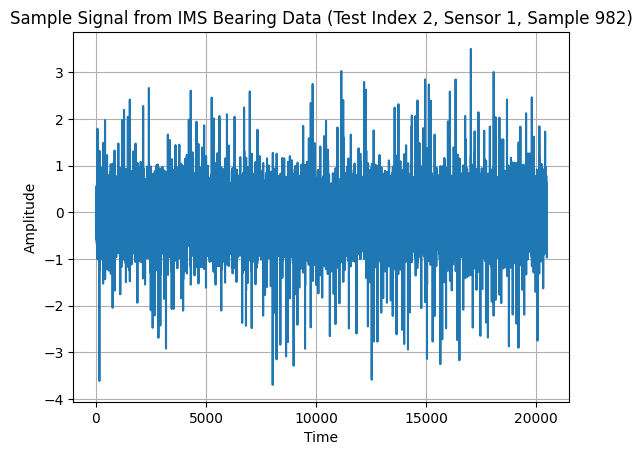

In [4]:
sig_start = preprocess.read(sample_num=1)
plt.figure()
plt.plot(sig_start[0])
plt.grid()
plt.title("Sample Signal from IMS Bearing Data (Test Index 2, Sensor 1, Sample 1)")
plt.xlabel("Time")
plt.ylabel("Amplitude")

sig_end = preprocess.read(sample_num=982)
plt.figure()
plt.plot(sig_end[0])
plt.grid()
plt.title("Sample Signal from IMS Bearing Data (Test Index 2, Sensor 1, Sample 982)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Dense

We can build a simle Encoder NN, to transform the signal into so-called latent space, and to detect if the bearing is in the fault situation.

The detail of the algorithm can be found in the reference of 

"N. Herwig, P. Borghesani, W. Smith, Z. Peng, and J. Antoni, “Explainable anomaly detection with neural networks for gear condition monitoring,” in Proc. 21st Australian International Aerospace Congress (AIAC), Melbourne & Avalon, Australia, Mar. 24–26, 2025, pp. 1–6."

![](./Images/image-4.png)

1. Select the first 300 samples as the training dataset
2. Moving Average FFT Spectrum is applied as the pre-process 
3. Build the NN model
4. Train the NN to compress the latent space into a circle
5. Apply the model with the left dataset to see if there's a trend with the development of expriment.

In [5]:
class DenseModel(nn.Module):
    def __init__(self, input_len=10241):
        super(DenseModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_len, 100, bias=False),
            nn.ReLU(),
            nn.Linear(100, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 2, bias=False)
        )
        
    def build_c(self, sig):
        c = self._get_c(sig)   
        self.register_buffer('c', c) 
        
        
    def _get_c(self, sig):
        with torch.no_grad():
            c = self.forward(sig) # (num_samples, 2)
            c = torch.mean(c, dim=0, keepdim=True)  # (1, 2)
        # c = torch.zeros(1, 2).to(sig.device)
        return c.detach()
    
    def _get_R(self, sig):
        # to test if self.c is defined, if not, raise error
        if not hasattr(self, 'c'):
            raise ValueError("Center c is not defined. Please run fit() first to compute c.")
        
        with torch.no_grad():
            latent = self.forward(sig)  # (num_samples, 2)
            R = torch.quantile(torch.sqrt(((latent - self.c)**2).sum(dim=1)), 0.99)
        return R

    def _loss_func(self, pred, target):
        # pred: (num_samples, 2)
        # target: (1, 2)
        L = ((pred - target)**2).sum(dim=1).mean()
        return L

    def fit(self, dataset, lr, epochs, batch_size):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        dataset.sig = dataset.sig.to(device)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-3)
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size = batch_size,
            shuffle = True
        )
        self.build_c(dataset.sig)

        self.train()
        for epoch in range(epochs):
            for sig in dataloader:
                latent = self.forward(sig)  # (batch_size, 2)
                loss = self._loss_func(latent, self.c)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    def predict(self, sig):
        self.eval()
        sig = sig.to(next(self.parameters()).device)
        with torch.no_grad():
            latent = self.forward(sig)
            return latent

    def forward(self, sig):
        sig = sig.view(sig.size(0), -1)  # flatten
        latent = self.layers(sig)
        return latent

In [6]:
model = DenseModel(input_len=1025)
model.fit(
    dataset_train,
    lr=1e-3,
    epochs=50,
    batch_size=16
)


Epoch 1/50, Loss: 0.0004
Epoch 2/50, Loss: 0.0004
Epoch 3/50, Loss: 0.0000
Epoch 4/50, Loss: 0.0000
Epoch 5/50, Loss: 0.0000
Epoch 6/50, Loss: 0.0000
Epoch 7/50, Loss: 0.0000
Epoch 8/50, Loss: 0.0000
Epoch 9/50, Loss: 0.0000
Epoch 10/50, Loss: 0.0000
Epoch 11/50, Loss: 0.0000
Epoch 12/50, Loss: 0.0000
Epoch 13/50, Loss: 0.0000
Epoch 14/50, Loss: 0.0000
Epoch 15/50, Loss: 0.0000
Epoch 16/50, Loss: 0.0000
Epoch 17/50, Loss: 0.0000
Epoch 18/50, Loss: 0.0000
Epoch 19/50, Loss: 0.0000
Epoch 20/50, Loss: 0.0000
Epoch 21/50, Loss: 0.0000
Epoch 22/50, Loss: 0.0000
Epoch 23/50, Loss: 0.0000
Epoch 24/50, Loss: 0.0000
Epoch 25/50, Loss: 0.0000
Epoch 26/50, Loss: 0.0000
Epoch 27/50, Loss: 0.0000
Epoch 28/50, Loss: 0.0000
Epoch 29/50, Loss: 0.0000
Epoch 30/50, Loss: 0.0000
Epoch 31/50, Loss: 0.0000
Epoch 32/50, Loss: 0.0000
Epoch 33/50, Loss: 0.0000
Epoch 34/50, Loss: 0.0000
Epoch 35/50, Loss: 0.0000
Epoch 36/50, Loss: 0.0000
Epoch 37/50, Loss: 0.0000
Epoch 38/50, Loss: 0.0000
Epoch 39/50, Loss: 0.

Have a look at the training dataset, to see if the data is final compressed into a circle. The boundary of the circle is set as 99% quantile of the radius to the latent space data center.

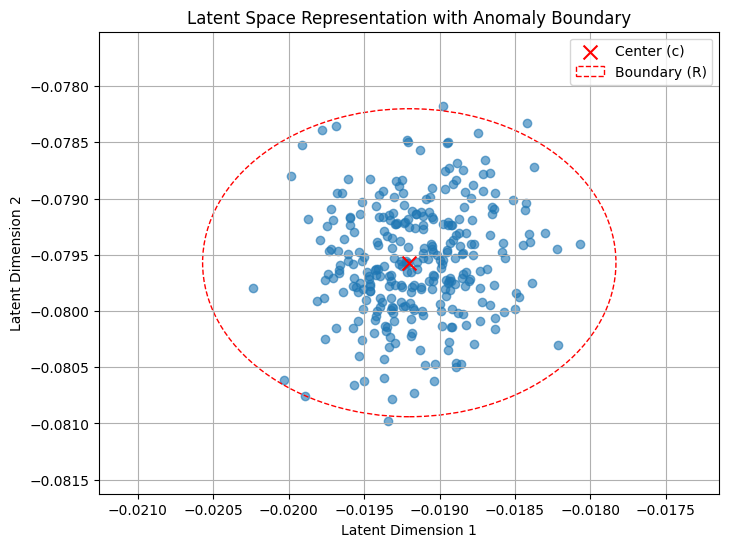

In [7]:
R = model._get_R(dataset_train.sig)
c = model.c

# plot the latent space
plt.figure(figsize=(8, 6))
latent_train = model.predict(dataset_train.sig).cpu().numpy()
plt.scatter(latent_train[:, 0], latent_train[:, 1], alpha=0.6)
plt.scatter(c[0,0].cpu(), c[0,1].cpu(), color='r', marker='x', s=100, label='Center (c)')
circle = plt.Circle((c[0,0].cpu(), c[0,1].cpu()), R.cpu(), color='r', fill=False, linestyle='--', label='Boundary (R)')
plt.gca().add_artist(circle)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation with Anomaly Boundary')
plt.legend()
plt.xlim(c[0,0].cpu()-R.cpu()*1.5, c[0,0].cpu()+R.cpu()*1.5)
plt.ylim(c[0,1].cpu()-R.cpu()*1.5, c[0,1].cpu()+R.cpu()*1.5)
plt.grid()


Have a look at final 100 samples, to see if the data is out of the circle

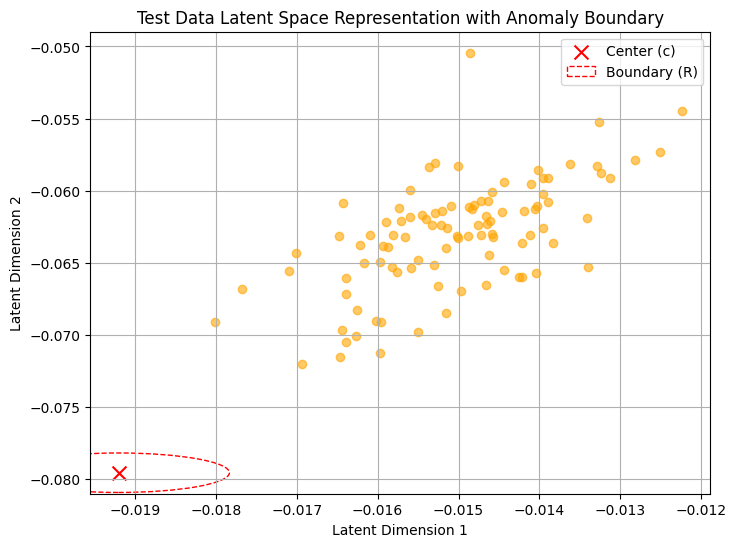

In [8]:
latent_test = model.predict(dataset_test.sig[-100:-1]).cpu().numpy()
plt.figure(figsize=(8, 6))
plt.scatter(latent_test[:, 0], latent_test[:, 1], alpha=0.6, color='orange')
plt.scatter(c[0,0].cpu(), c[0,1].cpu(), color='r', marker='x', s=100, label='Center (c)')
circle = plt.Circle((c[0,0].cpu(), c[0,1].cpu()), R.cpu(), color='r', fill=False, linestyle='--', label='Boundary (R)')
plt.gca().add_artist(circle)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Test Data Latent Space Representation with Anomaly Boundary')
plt.legend()
# plt.xlim(c[0,0].cpu()-R.cpu()*1.5, c[0,0].cpu()+R.cpu()*1.5)
# plt.ylim(c[0,1].cpu()-R.cpu()*1.5, c[0,1].cpu()+R.cpu()*1.5)
plt.grid()

To put all the data into the model to see if we could have a trend

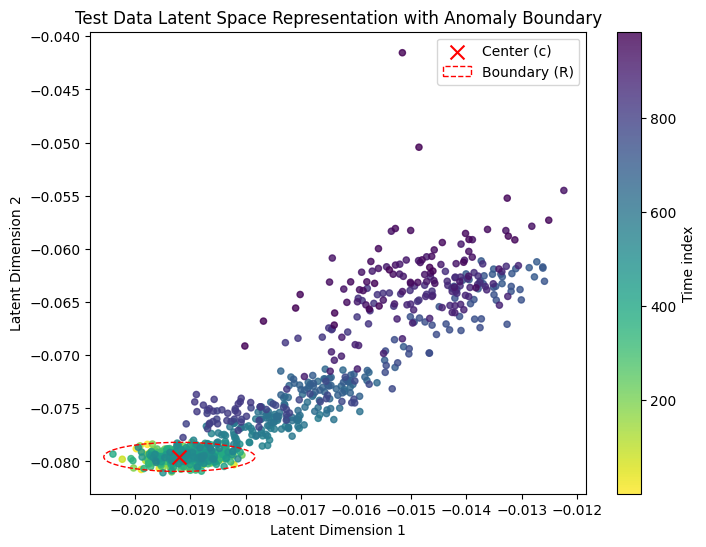

In [9]:
sig_train = dataset_train.sig.cpu()
sig_test = dataset_test.sig.cpu()

# merge them together
sig = torch.cat([sig_train, sig_test], dim=0)
series = np.arange(sig.shape[0]) + 1
latent = model.predict(sig).cpu().numpy()

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    latent[:, 0], latent[:, 1],
    c=series, cmap='viridis_r',  # 颜色随时间变化
    alpha=0.8, s=20
)
plt.colorbar(sc, label='Time index')
plt.scatter(c[0,0].cpu(), c[0,1].cpu(), color='r', marker='x', s=100, label='Center (c)')
circle = plt.Circle((c[0,0].cpu(), c[0,1].cpu()), R.cpu(), color='r', fill=False, linestyle='--', label='Boundary (R)')
plt.gca().add_artist(circle)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Test Data Latent Space Representation with Anomaly Boundary')
plt.legend()